In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import gc
import os
import sys
import torch
import torchaudio
import numpy as np
from torch import nn
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS

def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()
    
clear_cache()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_sample_rate = 8000
n_epochs = 15
batch_size = 256
lr = 3e-4
print(device)

cuda


In [3]:
class GetDataset(SPEECHCOMMANDS):
    def __init__(self, split):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if split == "validation":
            self._walker = load_list("validation_list.txt")
        elif split == "testing":
            self._walker = load_list("testing_list.txt")
        elif split == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [4]:
train_data = GetDataset("training")
test_data = GetDataset("testing")
waveform, sample_rate, label, speaker_id, utterance_number = train_data[42]
print(waveform.shape, sample_rate, label, speaker_id, utterance_number)

torch.Size([1, 16000]) 16000 backward 0b7ee1a0 0


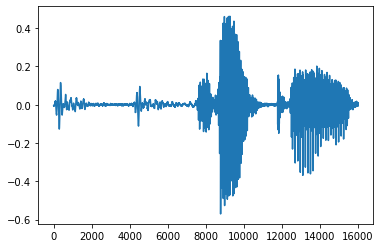

In [5]:
plt.plot(waveform.t().numpy())

In [6]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [7]:
labels = sorted(list(set(data[2] for data in train_data)))
l2i = lambda word: torch.tensor(labels.index(word))
i2l = lambda index: labels[index]
print(labels, len(labels))

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'] 35


In [8]:
T = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = T(waveform)
print(transformed.shape)
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

torch.Size([1, 8000])


In [9]:
def pad_sequence(batch):
    batch = [item.t() for item in batch] # (b, c, t) -> (b, t, c) doing this to pad the sequences
    batch = nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    batch = batch.permute(0, 2, 1) # (b, t, c) -> (b, c, t)
    return batch

def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [l2i(label)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
x, y = next(iter(train_loader))
print(len(train_loader), x.shape, y.shape)

332 torch.Size([256, 1, 16000]) torch.Size([256])


In [11]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_channel=32, stride=16, n_output=35):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(n_channel, n_channel, kernel_size=3),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3),
            nn.BatchNorm1d(2 * n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3),
            nn.BatchNorm1d(2 * n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        self.fc = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.block(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.squeeze(-1)
        x = self.fc(x)
        return x

In [12]:
m5 = M5().to(device)
inp = torch.randn(2, 1, 8000).to(device)
out = m5(inp)
print(out.shape)
clear_cache()

torch.Size([2, 35])


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m5.parameters(), lr=lr)
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [14]:
def loop(net, loader, epoch, is_train):
    net.train(is_train)
    losses = []
    accs = []
    pbar = tqdm(loader, total=len(loader))
    for x, y in pbar:
        x = T(x.to(device)) # (b, 1, 16k) -> (b, 1, 8k)
        y = y.to(device)
        with torch.set_grad_enabled(is_train):
            preds = net(x)
            loss = loss_fn(preds, y)
            acc = get_accuracy(preds, y)
            losses.append(loss.item())
            accs.append(acc.item())
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f'epoch={epoch}, train={int(is_train)}, loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}')

In [15]:
for epoch in range(n_epochs):
    loop(m5, train_loader, epoch, True)
    loop(m5, test_loader, epoch, False)

epoch=14, train=0, loss=0.7510, acc=0.7858: 100%|██████████| 43/43 [00:02<00:00, 15.21it/s]


In [30]:
def predict(waveform):
    w = waveform.to(device)
    w = T(w).unsqueeze(0) # (1, 16k) -> (1, 8k)
    w = m5(w).squeeze(0)
    pred = w.argmax(-1)
    pred = i2l(pred.item())
    return pred

In [34]:
def get_pred(i):
    w, _, l, *_ = test_data[i]
    pred = predict(w)
    print(f'prediction: {pred} | label: {l}')
    return ipd.Audio(w.numpy(), rate=sample_rate)

In [35]:
get_pred(0)

prediction: right | label: right


In [36]:
get_pred(42)

prediction: right | label: right
